# Preprocessing for complex PDF

## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../../.."
add_python_path(module_path)

python path: /home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr is added
sys.path:  ['/home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/02_qa_chatbot/01_preprocess_docs', '/home/ec2-user/anaconda3/envs/python3/lib/python310.zip', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/lib-dynload', '', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages', '/home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr']


## 1. Bedrock Client 생성

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [5]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7f95ed5d02e0>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f9624d5c250>])

### Embedding 모델 선택

In [7]:
from langchain.embeddings import BedrockEmbeddings

In [8]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. 데이터 준비 
- https://python.langchain.com/docs/integrations/document_loaders/unstructured_file
- cleansing: https://unstructured-io.github.io/unstructured/core/cleaning.html

### Extract Text, Table and Image from documents

In [9]:
from unstructured.cleaners.core import clean_bullets, clean_extra_whitespace
from langchain_community.document_loaders import UnstructuredFileLoader

Parameters
----------
- filename
    - A string defining the target filename path.
- content_type
    - A string defining the file content in MIME type
- file
    - A file-like object using "rb" mode --> open(filename, "rb").
- metadata_filename
    - When file is not None, the filename (string) to store in element metadata. E.g. "foo.txt"
- url
    - The url for a remote document. Pass in content_type if you want partition to treat the document as a specific content_type.
- include_page_breaks
    - If True, the output will include page breaks if the filetype supports it
- strategy
    - The strategy to use for partitioning PDF/image. Uses a layout detection model if set to 'hi_res', otherwise partition simply extracts the text from the document and processes it.
- encoding
    - The encoding method used to decode the text input. If None, utf-8 will be used.
- headers
    - The headers to be used in conjunction with the HTTP request if URL is set.
- skip_infer_table_types
    - The document types that you want to skip table extraction with.
- ssl_verify
    - If the URL parameter is set, determines whether or not partition uses SSL verification in the HTTP request.
- languages
    - The languages present in the document, for use in partitioning and/or OCR. For partitioning <BR>
    image or pdf documents with Tesseract, you'll first need to install the appropriate <BR>
    Tesseract language pack. For other partitions, language is detected using naive Bayesian <BR>
    filter via `langdetect`. Multiple languages indicates text could be in either language. <BR>
    Additional Parameters: <BR>
        - detect_language_per_element <BR>
            - Detect language per element instead of at the document level.
    
- pdf_infer_table_structure
    - If True and strategy=hi_res, any Table Elements extracted from a PDF will include an
    additional metadata field, "text_as_html," where the value (string) is a just a
    transformation of the data into an HTML <table>.
    The "text" field for a partitioned Table Element is always present, whether True or False.
- extract_images_in_pdf
    - Only applicable if `strategy=hi_res`.
    If True, any detected images will be saved in the path specified by
    'extract_image_block_output_dir' or stored as base64 encoded data within metadata fields.
    Deprecation Note: This parameter is marked for deprecation. Future versions will use
    'extract_image_block_types' for broader extraction capabilities.
- extract_image_block_types
    - Only applicable if `strategy=hi_res`.
    Images of the element type(s) specified in this list (e.g., ["Image", "Table"]) will be
    saved in the path specified by 'extract_image_block_output_dir' or stored as base64
    encoded data within metadata fields.
- extract_image_block_to_payload
    - Only applicable if `strategy=hi_res`.
    If True, images of the element type(s) defined in 'extract_image_block_types' will be
    encoded as base64 data and stored in two metadata fields: 'image_base64' and
    'image_mime_type'.
    This parameter facilitates the inclusion of element data directly within the payload,
    especially for web-based applications or APIs.
- extract_image_block_output_dir
    - Only applicable if `strategy=hi_res` and `extract_image_block_to_payload=False`.
    The filesystem path for saving images of the element type(s)
    specified in 'extract_image_block_types'.
- xml_keep_tags
    - If True, will retain the XML tags in the output. Otherwise it will simply extract
    the text from within the tags. Only applies to partition_xml.
- request_timeout
    - The timeout for the HTTP request if URL is set. Defaults to None meaning no timeout and
    requests will block indefinitely.
- hi_res_model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`.
- model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`. To be
    deprecated in favor of `hi_res_model_name`.

In [110]:
loader = UnstructuredFileLoader(
    file_path="./data/complex_pdf/sample.pdf",
    #file_path="./data/complex_pdf/dart-short-sample.pdf",
    
    mode="elements",

    strategy="hi_res",
    hi_res_model_name="yolox",

    extract_images_in_pdf=True,
    #skip_infer_table_types='[]',
    pdf_infer_table_structure=False,

    extract_image_block_output_dir="./fig",
    extract_image_block_to_payload=True,

    post_processors=[clean_bullets, clean_extra_whitespace]
)

In [111]:
%%time
docs = loader.load()

CPU times: user 11.2 s, sys: 29.3 ms, total: 11.2 s
Wall time: 15.9 s


In [112]:
tables, images, texts = [], [], []

for doc in docs:

    category = doc.metadata["category"]

    if category == "Table": tables.append(doc)
    elif category == "Image": images.append(doc)
    else: texts.append(doc)
    
print (f' # texts: {len(texts)} \n # tables: {len(tables)} \n # images: {len(images)}')

 # texts: 56 
 # tables: 2 
 # images: 3


### Summarization of table and image
- BedrockChat with claude3: https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8

In [113]:
from langchain.schema import Document
from langchain_core.messages import HumanMessage
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

In [114]:
system_prompt = "You are an assistant tasked with summarizing table and image."
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

### For images

In [115]:
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [116]:
human_prompt = [
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/png;base64," + "{image_base64}",
        },
    },
    {
        "type": "text",
        "text": '''
                 Here is the text: <text>{text}</text>
                 Given image and text, give a concise summary.
                 Don't insert any XML tag such as <text> and </text> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [117]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

#summarize_chain = prompt | llm_text | StrOutputParser()
summarize_chain = {"image_base64": lambda x:x[0], "text": lambda x:x[1]} | prompt | llm_text | StrOutputParser()

In [118]:
img_info = [(i.metadata["image_base64"], i.page_content) for i in images]
image_summaries = summarize_chain.batch(img_info, config={"max_concurrency": 1})

이 이미지는 검은색 배경에 "핵심설명서"라는 한국어 텍스트가 있습니다. 이 텍스트는 책이나 교재의 제목으로 보이며, 아마도 중요한 내용을 요약한 설명서를 의미할 것입니다. 전체적으로 심플하고 명확한 디자인으로, 핵심 내용에 집중하게 합니다.이 그래프는 기준 투자 대비 투자 성과를 보여줍니다. 세로축은 세전 수익률을, 가로축은 기준 기준자산 가치 대비 투자 기준자산 가치의 비율을 나타냅니다. 기준 투자 대비 100%일 때 수익률은 21%이며, 기준자산 가치가 130%일 때는 수익률이 약 70%가 되는 것으로 보입니다. 이 그래프를 통해 투자 수익률과 기준자산 가치 상승의 관계를 한눈에 알아볼 수 있습니다.이 이미지는 효율성 기준에 따른 상승곡선을 나타내고 있습니다. X축은 적중기준가격대비 투자자산가치의 퍼센트를 나타내고, Y축은 서전수익률을 나타냅니다. 원금보전 지점에서 100%의 적중기준가격대비 투자자산가치를 보이고 있으며, 상승곡선을 따라 130%에서 상승곡선여율이 70%에 이르는 것으로 나타납니다. 마지막으로 21%의 서전수익률을 보여주고 있습니다.

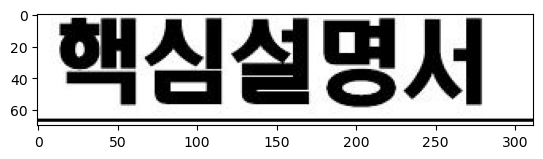

Summary: 이 이미지는 검은색 배경에 "핵심설명서"라는 한국어 텍스트가 있습니다. 이 텍스트는 책이나 교재의 제목으로 보이며, 아마도 중요한 내용을 요약한 설명서를 의미할 것입니다. 전체적으로 심플하고 명확한 디자인으로, 핵심 내용에 집중하게 합니다.
Desc: 핵심설명서


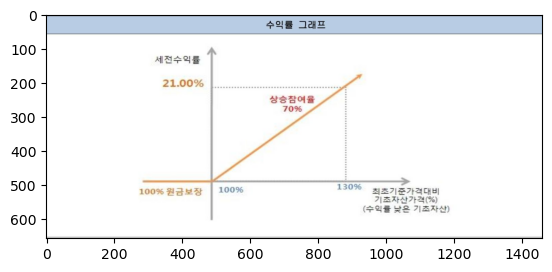

Summary: 이 그래프는 기준 투자 대비 투자 성과를 보여줍니다. 세로축은 세전 수익률을, 가로축은 기준 기준자산 가치 대비 투자 기준자산 가치의 비율을 나타냅니다. 기준 투자 대비 100%일 때 수익률은 21%이며, 기준자산 가치가 130%일 때는 수익률이 약 70%가 되는 것으로 보입니다. 이 그래프를 통해 투자 수익률과 기준자산 가치 상승의 관계를 한눈에 알아볼 수 있습니다.
Desc: 수익률 그래프


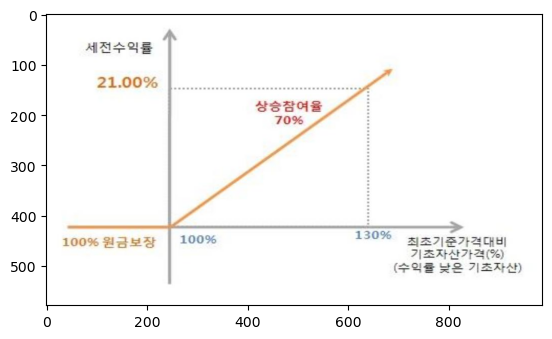

Summary: 이 이미지는 효율성 기준에 따른 상승곡선을 나타내고 있습니다. X축은 적중기준가격대비 투자자산가치의 퍼센트를 나타내고, Y축은 서전수익률을 나타냅니다. 원금보전 지점에서 100%의 적중기준가격대비 투자자산가치를 보이고 있으며, 상승곡선을 따라 130%에서 상승곡선여율이 70%에 이르는 것으로 나타납니다. 마지막으로 21%의 서전수익률을 보여주고 있습니다.
Desc: HE=HE 21.00% 4STEHE 70% 130% m=oz=spzgpy| IR AT (%) (B 22 7| =X 100% HSEF


In [119]:
verbose = True
if verbose:
    for (img, desc), summary in zip(img_info, image_summaries):
        
        print ("============================")
        img = Image.open(BytesIO(base64.b64decode(img)))
        plt.imshow(img)
        plt.show()
        
        print (f'Summary: {summary}')
        print (f'Desc: {desc}')

`요약`된 내용을 Document의 `page_content`로, `OCR`결과는 metadata의 `origin_image`로 사용

In [120]:
images_preprocessed = []

for origin, summary in zip(images, image_summaries):
    metadata = origin.metadata
    metadata["origin_image"] = origin.page_content
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    images_preprocessed.append(doc)

### For tables

In [121]:
human_prompt = [
    {
        "type": "text",
        "text": '''
                 Here is the table: <table>{table}</table>
                 Given table, give a concise summary.
                 Don't insert any XML tag such as <table> and </table> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [122]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

#summarize_chain = prompt | llm_text | StrOutputParser()
summarize_chain = {"table": lambda x:x} | prompt | llm_text | StrOutputParser()

In [123]:
table_info = [t.page_content for t in tables]
table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})

이 표는 만기상환금액의 산정 방식을 설명하고 있습니다. 만기평가가격이 최초기준가격의 100% 이상일 경우, 만기상환금액은 {(만기평가가격/최초기준가격) × 70%}로 계산됩니다. 반면 만기평가가격이 최초기준가격의 100% 미만일 경우, 만기상환금액은 총액면금액의 100%로 지급됩니다.제시된 표는 주가연계증권(ELS)의 상품 구조를 보여줍니다. 최초 기준가격 결정일에 KOSPI200 지수는 250pt, 기초자산 금 가격은 1,500달러였습니다. 만기평가일 1에는 KOSPI200 지수가 20% 상승하고 금 가격이 10% 상승하여 수익률 7.0%와 세전 이익 700만원을 실현했습니다. 반면 만기평가일 2에는 KOSPI200 지수는 20% 상승했지만 금 가격이 10% 하락하여 손실이 발생했습니다.

In [126]:
verbose = True
if verbose:
    for table, summary in zip(table_info, table_summaries):
        
        print ("============================")
        print (f'table: {table}')
        print ("----------------------------")
        print (f'Summary: {summary}')
        

table: 구 분 내 용 만기상환금액 ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 만기 익률이 낮은 기초자산 기준) 기준가격) /최초기준가격 × 70%}] 상환 ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) 총액면금액×100%
----------------------------
Summary: 이 표는 만기상환금액의 산정 방식을 설명하고 있습니다. 만기평가가격이 최초기준가격의 100% 이상일 경우, 만기상환금액은 {(만기평가가격/최초기준가격) × 70%}로 계산됩니다. 반면 만기평가가격이 최초기준가격의 100% 미만일 경우, 만기상환금액은 총액면금액의 100%로 지급됩니다.
table: 결정일 KOSPI200 금 수익률 손익(세전) 최초기준가격결정일 250pt 1,500 달러 - - 만기평가일 1 300pt (20%상승) 1,650 달러 (10%상승) 7.0% +700 만원 만기평가일 2 300pt (20%상승) 1,350 달러 (10%하락) - -
----------------------------
Summary: 제시된 표는 주가연계증권(ELS)의 상품 구조를 보여줍니다. 최초 기준가격 결정일에 KOSPI200 지수는 250pt, 기초자산 금 가격은 1,500달러였습니다. 만기평가일 1에는 KOSPI200 지수가 20% 상승하고 금 가격이 10% 상승하여 수익률 7.0%와 세전 이익 700만원을 실현했습니다. 반면 만기평가일 2에는 KOSPI200 지수는 20% 상승했지만 금 가격이 10% 하락하여 손실이 발생했습니다.


`요약`된 내용을 Document의 `page_content`로, `parsed table`은 metadata의 `origin_table`로 사용

In [127]:
tables_preprocessed = []

for origin, summary in zip(tables, table_summaries):
    metadata = origin.metadata
    metadata["origin_table"] = origin.page_content
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    tables_preprocessed.append(doc)

### Text Spliter 로 청킹
참고: 검색된 문서/텍스트는 질문에 대답하기에 충분한 정보를 포함할 만큼 커야 합니다. 하지만 LLM 프롬프트에 들어갈 만큼 충분히 작습니다. <BR>
또한 임베딩 모델에는 입력 토큰 길이는 KoSimCSERobert는 512개, titanEmbedding(8,912개) 토큰으로 제한되어 있습니다. <BR>
이 사용 사례를 위해 [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/modules/indexes/text_splitters/examples/recursive_text_splitter.html)를 사용하여 500자가 겹치는 약 92자의 청크를 생성합니다.

In [128]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [129]:
chunk_size = 1024
chunk_overlap = 50

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators=["\n\n", "\n", ".", " ", ""],
    length_function=len,
)

texts_preprocessed = text_splitter.split_documents(texts)
print(f"Number of documents after split and chunking={len(texts_preprocessed)}")

Number of documents after split and chunking=56


### Merge text, table and image

In [130]:
from itertools import chain

In [131]:
docs_preprocessed = list(chain(texts_preprocessed, tables_preprocessed, images_preprocessed))

[Document(page_content='이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여 금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을 충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.', metadata={'source': './data/complex_pdf/sample.pdf', 'detection_class_prob': 0.3390708267688751, 'coordinates': {'points': ((112.57894134521484, 41.28585433959961), (112.57894134521484, 164.21746826171875), (1547.0444444444445, 164.21746826171875), (1547.0444444444445, 41.28585433959961)), 'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339}, 'last_modified': '2024-03-13T13:49:55', 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 1, 'file_directory': './data/complex_pdf', 'filename': 'sample.pdf', 'category': 'Title'}),
 Document(page_content='[미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]', metadata={'source': './data/complex_pdf/sample.pdf', 'detection_class_prob': 0.5520003437995911, 'coordinates': {'points': ((309.12457275390625, 357.5935555555554), (309.12457275390625, 398.43634033203125), (1348.2647777777777, 398.4363

## 4. Index 생성

### Index 이름 결정

In [132]:
import boto3
from utils.ssm import parameter_store

In [133]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [134]:
index_name = "kb_complex_pdf"

In [135]:
pm.put_params(
    key="opensearch_index_name",
    value=f'{index_name}',
    overwrite=True,
    enc=False
)

Parameter stored successfully.


### Index 스키마 정의

In [136]:
index_body = {
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer': {
                         'char_filter':['html_strip'],
                    'tokenizer': 'nori',
                    'filter': [
                        #'nori_number',
                        #'lowercase',
                        #'trim',
                        'my_nori_part_of_speech'
                    ],
                    'type': 'custom'
                }
            },
            'tokenizer': {
                'nori': {
                    'decompound_mode': 'mixed',
                    'discard_punctuation': 'true',
                    'type': 'nori_tokenizer'
                }
            },
            "filter": {
                "my_nori_part_of_speech": {
                    "type": "nori_part_of_speech",
                    "stoptags": [
                        "J", "XSV", "E", "IC","MAJ","NNB",
                        "SP", "SSC", "SSO",
                        "SC","SE","XSN","XSV",
                        "UNA","NA","VCP","VSV",
                        "VX"
                    ]
                }
            }
        },
        'index': {
            'knn': True,
            'knn.space_type': 'cosinesimil'  # Example space type
        }
    },
    'mappings': {
        'properties': {
            'metadata': {
                'properties': {
                    'source': {'type': 'keyword'},
                    'page_number': {'type':'long'},
                    'category': {'type':'text'},
                    'file_directory': {'type':'text'},
                    'last_modified': {'type': 'text'},
                    'type': {'type': 'keyword'},
                    'image_base64': {'type':'text'},
                    'origin_image': {'type':'text'},
                    'origin_table': {'type':'text'},
                }
            },
            'text': {
                'analyzer': 'my_analyzer',
                'search_analyzer': 'my_analyzer',
                'type': 'text'
            },
            'vector_field': {
                'type': 'knn_vector',
                'dimension': f"{dimension}" # Replace with your vector dimension
            }
        }
    }
}


## 5. LangChain OpenSearch VectorStore 생성 
### 선수 조건

#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.

In [137]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [138]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### OpenSearch Client 생성

In [139]:
from local_utils.opensearch import opensearch_utils

In [140]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

### 오픈 서치 인덱스 생성 
- 오픈 서치에 해당 인덱스가 존재하면, 삭제 합니다. 

In [141]:
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)

if index_exists:
    opensearch_utils.delete_index(
        os_client,
        index_name
    )

opensearch_utils.create_index(os_client, index_name, index_body)
index_info = os_client.indices.get(index=index_name)
print("Index is created")
pprint(index_info)

index_name=kb_complex_pdf, exists=True

Deleting index:
{'acknowledged': True}

Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'kb_complex_pdf'}
Index is created
{'kb_complex_pdf': {'aliases': {},
                    'mappings': {'properties': {'metadata': {'properties': {'category': {'type': 'text'},
                                                                            'file_directory': {'type': 'text'},
                                                                            'image_base64': {'type': 'text'},
                                                                            'last_modified': {'type': 'text'},
                                                                            'origin_image': {'type': 'text'},
                                                                            'origin_table': {'type': 'text'},
                                                                            'page_number': {'type': 'long'},
     

### 랭체인 인덱스 연결 오브젝트 생성

- [langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.html)

In [142]:
from langchain.vectorstores import OpenSearchVectorSearch

In [143]:
vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    opensearch_url=opensearch_domain_endpoint,
    embedding_function=llm_emb,
    http_auth=http_auth, # http_auth
    is_aoss=False,
    engine="faiss",
    space_type="l2",
    bulk_size=100000,
    timeout=60
)
vector_db

### OpenSearch 에 문서 삽입

In [144]:
%%time

vector_db.add_documents(
    documents = docs_preprocessed, 
    vector_field = "vector_field",
    bulk_size = 1000000
)

CPU times: user 217 ms, sys: 25 µs, total: 217 ms
Wall time: 8.61 s


['4360d034-cab7-4beb-9fe0-bcc5140097f8',
 'e3a8d831-b9ce-4865-b6d3-d3de645cc036',
 '89882fbb-f556-433a-8f2d-ad424437abab',
 'aad065c3-65d0-4038-9c12-f932c8e0afbd',
 'ce18faf2-df8b-44ed-8d93-ce90bd7e9188',
 'e2ef1dc9-b881-4e12-94ba-6b69dc826784',
 'c589c80e-dda2-4185-a9c4-5c77cb222ce1',
 'ca24a834-3619-45e0-a53c-05d99e819792',
 '8471b6fc-0f1b-49f2-a290-5cd8027b5782',
 '67efab64-2938-475c-aebc-c83af03049b3',
 'e1f1e94a-6c93-40e1-be11-3efafb6e1eb9',
 'a2afc925-07be-4854-be6c-26d62132ea23',
 'b4bec6d0-2ae4-48a4-9638-882070f9d96c',
 '63c8231c-09c5-4cd1-842e-a7da3e15f609',
 '3790df81-edef-4242-b659-456db29a2e14',
 'fbbd8998-10ef-4338-91b0-6eb6356ba786',
 '13beab65-496a-4bfa-aae8-5072114e4c35',
 '5183a5a7-5222-45ba-ab48-d7f8c07b30eb',
 '192673e0-42ee-4775-ae85-268772c02ac5',
 'a5840042-bb92-4b87-b4b2-71bd369c934b',
 '21c8879c-7fed-40bd-a730-260389542409',
 '14a81b13-4208-4890-bbbb-fecac412f3a3',
 'b6c94f1e-85a8-4ffb-8470-ed4e2394c77b',
 '7292304a-a00a-4d03-8f3e-3d526060e3a2',
 '10b048d8-4f53-

## 6. 검색 테스트

In [145]:
from utils.rag import qa_chain_complex_pdf
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

In [146]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document = False, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_pdf=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=7, # 최종 Document 수 정의
    verbose=False,
)

### 하이브리드 검색

In [157]:
query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"
#query = "만기가격이 기준가격의 80% 일 때 만기상환금액 계산하는 방법 알려줘"
query = "수익률 그래프 설명해줘"

search_filter=[
    #{"term": {"metadata.source": "신한은행"}},
    #{"term": {"metadata.type": "인터넷뱅킹"}},
]

In [155]:
%%time
search_hybrid_result, tables, images = opensearch_hybrid_retriever.get_relevant_documents(query)
#show_context_used(search_hybrid_result)

CPU times: user 12.8 ms, sys: 32 µs, total: 12.8 ms
Wall time: 122 ms


In [156]:
show_context_used(search_hybrid_result)

-----------------------------------------------
1. Category: Table, Chunk: 159 Characters
-----------------------------------------------
이 표는 만기상환금액의 산정 방식을 설명하고 있습니다. 만기평가가격이 최초기준가격의 100% 이상일 경우, 만기상환금액은 {(만기평가가격/최초기준가격) × 70%}로 계산됩니다.
반면 만기평가가격이 최초기준가격의 100% 미만일 경우, 만기상환금액은 총액면금액의 100%로 지급됩니다.
metadata:
 {'source': './data/complex_pdf/sample.pdf', 'detection_class_prob': 0.7832361459732056,
'coordinates': {'points': [[80.69361877441406, 1239.41259765625], [80.69361877441406,
1504.050048828125], [1566.467041015625, 1504.050048828125], [1566.467041015625, 1239.41259765625]],
'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339}, 'last_modified':
'2024-03-13T13:49:55', 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 1,
'parent_id': 'f1d0f6667f28d555fc05578bb3e90881', 'file_directory': './data/complex_pdf', 'filename':
'sample.pdf', 'category': 'Table', 'origin_table': '구 분 내 용 만기상환금액 ① 만기평가가격이 최초기준가격의 100% 이상인 경우
(만기수 만기 익률이 낮은 기초자산 기준) 기준가격) /최초기준가격 